# EC48E Assignment 4
## Melih Karaköse 2019205090
## Fethi Kahvecioğlu 2019402051

In [122]:
# Import libraries to use logistic regression
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.linear_model import Ridge, Lasso, ElasticNet 
from sklearn.model_selection import train_test_split, LeaveOneOut, KFold, cross_val_score, GridSearchCV
from sklearn.metrics import mean_squared_error, roc_curve, roc_auc_score, classification_report, confusion_matrix, accuracy_score, r2_score
from sklearn.calibration import cross_val_predict
from sklearn.tree import DecisionTreeClassifier, plot_tree
import itertools
import statsmodels.api as sm
from scipy.stats import skew, kurtosis
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import StandardScaler
import networkx as nx
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import warnings
import pydot
from tensorflow.keras.utils import plot_model
import graphviz
warnings.filterwarnings("ignore")

In [48]:
credit_data = pd.read_csv('csv_files/credit.csv')

In [49]:
credit_data = credit_data.drop(columns=['Unnamed: 0'])

In [50]:
# Run logistic regression using WC/TA, RE/TA, EBIT/TA, ME/TL, S/TA with 50% benchmark
X = credit_data[['WC/TA', 'RE/TA', 'EBIT/TA', 'ME/TL', 'S/TA']]
y = credit_data['Default']

weight_for_0 = 0.5  # Weight for the non-default class
weight_for_1 = 0.5  # Weight for the default class

class_weights = {0: weight_for_0, 1: weight_for_1}

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

logistic = linear_model.LogisticRegression(class_weight=class_weights)
logistic.fit(X_train, y_train)
y_pred = logistic.predict(X_train)


In [51]:
print('R2 Score:', r2_score(y_train, y_pred))
print('Accuracy Score:', accuracy_score(y_train, y_pred))
print('Confusion Matrix:', confusion_matrix(y_train, y_pred))

R2 Score: -0.06891403426056897
Accuracy Score: 0.9088191330343797
Confusion Matrix: [[600   6]
 [ 55   8]]


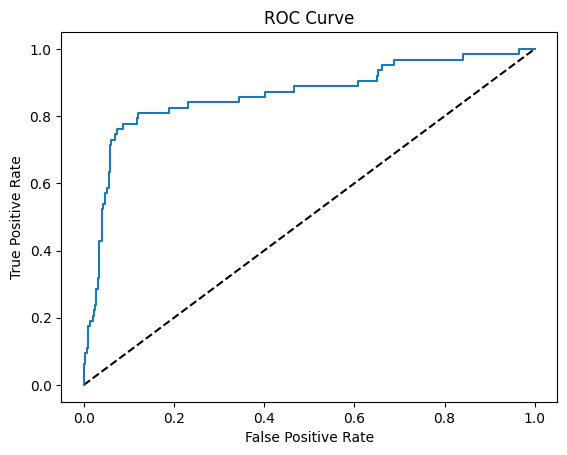

ROC AUC Score: 0.8632196552988631


In [52]:
# Create ROC Curve
y_pred_proba = logistic.predict_proba(X_train)[:,1]
fpr, tpr, thresholds = roc_curve(y_train, y_pred_proba)
plt.plot([0,1],[0,1],'k--')
plt.plot(fpr,tpr, label='Logistic Regression')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

# Print ROC Curve Statistics
print('ROC AUC Score:', roc_auc_score(y_train, y_pred_proba))

Test Truth Table
Accuracy Score: 0.9066666666666666
Confusion Matrix: [[67  1]
 [ 6  1]]


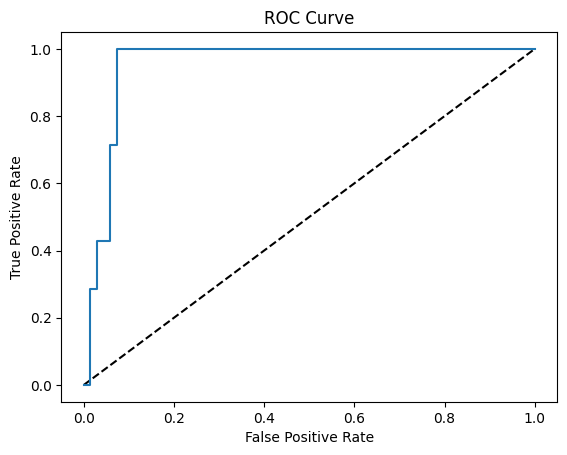

ROC AUC Score: 0.9537815126050421


In [53]:
y_pred_test = logistic.predict(X_test)

# Calculate truth table for test
print('Test Truth Table')
print('Accuracy Score:', accuracy_score(y_test, y_pred_test))
print('Confusion Matrix:', confusion_matrix(y_test, y_pred_test))

# Create ROC Curve for test
y_pred_proba = logistic.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.plot([0,1],[0,1],'k--')
plt.plot(fpr,tpr, label='Logistic Regression')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

# Print ROC Curve Statistics
print('ROC AUC Score:', roc_auc_score(y_test, y_pred_proba))


In [54]:
loo = LeaveOneOut()

# Initialize lists to store predictions and actual labels
predictions = []
true_labels = []

# Iterate through each training and testing set from LOOCV
for train_index, test_index in loo.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Fit the logistic regression model
    logistic = linear_model.LogisticRegression(class_weight=class_weights)
    logistic.fit(X_train, y_train)

    # Predict the labels for the test set
    y_pred = logistic.predict(X_test)

    # Store the predictions and true labels
    predictions.append(y_pred)
    true_labels.append(y_test.values[0])

# Convert lists to arrays for easier manipulation
predictions = np.array(predictions)
true_labels = np.array(true_labels)

# Calculate accuracy
accuracy = accuracy_score(true_labels, predictions)

# Calculate confusion matrix
conf_matrix = confusion_matrix(true_labels, predictions)

# Print results
print("Accuracy:", accuracy)
print("Confusion Matrix:")
print(conf_matrix)

# Calculate ROC AUC score
y_pred_proba = logistic.predict_proba(X)[:,1]
roc_auc = roc_auc_score(y, y_pred_proba)
print("ROC AUC Score:", roc_auc)

Accuracy: 0.907258064516129
Confusion Matrix:
[[667   7]
 [ 62   8]]
ROC AUC Score: 0.8739296311996609


In [55]:
# Define the number of folds
k = 10

# Initialize lists to store predictions and actual labels
predictions = []
true_labels = []

# Initialize KFold
kf = KFold(n_splits=k)

# Iterate through each fold
for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Fit the logistic regression model
    logistic = linear_model.LogisticRegression(class_weight=class_weights)
    logistic.fit(X_train, y_train)

    # Predict the labels for the test set
    y_pred = logistic.predict(X_test)

    # Store the predictions and true labels
    predictions.extend(y_pred)
    true_labels.extend(y_test)

# Convert lists to arrays for easier manipulation
predictions = np.array(predictions)
true_labels = np.array(true_labels)

# Calculate accuracy
accuracy = accuracy_score(true_labels, predictions)

# Calculate confusion matrix
conf_matrix = confusion_matrix(true_labels, predictions)

# Print results
print("Accuracy:", accuracy)
print("Confusion Matrix:")
print(conf_matrix)

# Calculate ROC AUC score
y_pred_proba = logistic.predict_proba(X)[:,1]
roc_auc = roc_auc_score(y, y_pred_proba)
print("ROC AUC Score:", roc_auc)

Accuracy: 0.8978494623655914
Confusion Matrix:
[[667   7]
 [ 69   1]]
ROC AUC Score: 0.8763459092835947


In [56]:
# Function to perform Best Subset Regression
def best_subset_regression(X, y, criterion='aic'):
    results = []
    for k in range(1, len(X.columns) + 1):
        subsets = itertools.combinations(X.columns, k)
        for subset in subsets:
            model = sm.Logit(y, sm.add_constant(X[list(subset)])).fit(disp=0)
            if criterion == 'aic':
                results.append((model, model.aic, subset))
            elif criterion == 'bic':
                results.append((model, model.bic, subset))
    
    # Select the model with the minimum AIC/BIC
    best_model = min(results, key=lambda x: x[1])
    return best_model

# Perform Best Subset Regression using BIC
best_model_bic = best_subset_regression(X, y, criterion='bic')
print("\nBest Subset Regression using BIC:")
print("BIC:", best_model_bic[1])
print("Variables:", best_model_bic[2])
print(best_model_bic[0].summary())



Best Subset Regression using BIC:
BIC: 365.72154205076663
Variables: ('RE/TA', 'ME/TL')
                           Logit Regression Results                           
Dep. Variable:                Default   No. Observations:                  744
Model:                          Logit   Df Residuals:                      741
Method:                           MLE   Df Model:                            2
Date:                Sat, 18 May 2024   Pseudo R-squ.:                  0.2547
Time:                        16:13:29   Log-Likelihood:                -172.94
converged:                       True   LL-Null:                       -232.05
Covariance Type:            nonrobust   LLR p-value:                 2.145e-26
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.8320      0.235     -3.543      0.000      -1.292      -0.372
RE/TA         -1.1031      0.288     -3.82

# Part B

## Part B - a

In [57]:
X = credit_data[['WC/TA', 'RE/TA', 'EBIT/TA', 'ME/TL', 'S/TA']]  # predictors
y = credit_data['Default']   # response

ridge = Ridge()
parameters = {'alpha': np.logspace(-4, 4, 100)}
ridge_cv = GridSearchCV(ridge, parameters, cv=10, scoring='neg_mean_squared_error')
ridge_cv.fit(X, y)

ridge_best_model = ridge_cv.best_estimator_
ridge_coefficients = ridge_best_model.coef_
print("Ridge coefficients:", ridge_coefficients)

Ridge coefficients: [ 0.01264678 -0.19656106 -1.03983187 -0.00933357  0.16121051]


In [58]:
lasso = Lasso()
parameters = {'alpha': np.logspace(-4, 4, 100)}
lasso_cv = GridSearchCV(lasso, parameters, cv=10, scoring='neg_mean_squared_error')
lasso_cv.fit(X, y)

lasso_best_model = lasso_cv.best_estimator_
lasso_coefficients = lasso_best_model.coef_
print("LASSO coefficients:", lasso_coefficients)


LASSO coefficients: [ 0.00666395 -0.19746534 -0.95038793 -0.00953055  0.15669492]


In [59]:
elastic_net = ElasticNet()
parameters = {'alpha': np.logspace(-4, 4, 100), 'l1_ratio': np.linspace(0, 1, 10)}
elastic_net_cv = GridSearchCV(elastic_net, parameters, cv=10, scoring='neg_mean_squared_error')
elastic_net_cv.fit(X, y)

elastic_net_best_model = elastic_net_cv.best_estimator_
elastic_net_coefficients = elastic_net_best_model.coef_
print("Elastic Net coefficients:", elastic_net_coefficients)

Elastic Net coefficients: [ 0.00949651 -0.19815175 -0.95745231 -0.00955268  0.15875159]


### Commentary on Coefficients

Let's analyze and comment on the coefficients obtained from Ridge, LASSO, and Elastic Net regression models. Here's a detailed commentary:

#### Ridge Regression Coefficients

Ridge coefficients: [ 0.01264678 -0.19656106 -1.03983187 -0.00933357  0.16121051]

- **Overview**: Ridge regression shrinks the coefficients but retains all features in the model. It uses \( \ell_2 \)-norm regularization, which penalizes the sum of the squared coefficients.
- **Interpretation**:
  - The first coefficient (0.0126) indicates a small positive effect of the corresponding predictor.
  - The second coefficient (-0.1966) indicates a moderate negative effect.
  - The third coefficient (-1.0398) indicates a strong negative effect, suggesting this predictor is significantly inversely related to the response variable.
  - The fourth coefficient (-0.0093) indicates a very small negative effect.
  - The fifth coefficient (0.1612) indicates a moderate positive effect.
- **Key Point**: Ridge does not set any coefficients to zero, hence all features are retained in the model.

#### LASSO Regression Coefficients

LASSO coefficients: [ 0.00666395 -0.19746534 -0.95038793 -0.00953055  0.15669492]

- **Overview**: LASSO regression can shrink some coefficients to exactly zero using \( \ell_1 \)-norm regularization, which is useful for feature selection.
- **Interpretation**:
  - The first coefficient (0.0067) is close to zero but positive, indicating a minimal positive effect.
  - The second coefficient (-0.1975) is slightly stronger than in Ridge, indicating a moderate negative effect.
  - The third coefficient (-0.9504) is still negative but slightly less strong than in Ridge.
  - The fourth coefficient (-0.0095) indicates a very small negative effect, similar to Ridge.
  - The fifth coefficient (0.1567) indicates a moderate positive effect.
- **Key Point**: In this case, none of the coefficients are exactly zero, indicating that LASSO did not perform feature selection here, but the coefficients are generally smaller in magnitude compared to Ridge.

#### Elastic Net Regression Coefficients

Elastic Net coefficients: [ 0.00949651 -0.19815175 -0.95745231 -0.00955268  0.15875159]

- **Overview**: Elastic Net combines both \( \ell_1 \) and \( \ell_2 \)-norm regularization, balancing Ridge and LASSO properties.
- **Interpretation**:
  - The first coefficient (0.0095) is positive and small, indicating a minimal positive effect.
  - The second coefficient (-0.1982) is a moderate negative effect, similar to LASSO.
  - The third coefficient (-0.9575) is negative, closer to LASSO but slightly more than Ridge.
  - The fourth coefficient (-0.0096) indicates a very small negative effect, very close to Ridge and LASSO.
  - The fifth coefficient (0.1588) indicates a moderate positive effect, similar to LASSO and Ridge.
- **Key Point**: Elastic Net coefficients are similar to those of LASSO but slightly more balanced, showcasing a compromise between the Ridge and LASSO results.

### Summary of Comparison
- **Magnitude**: Ridge generally produces larger coefficients compared to LASSO and Elastic Net due to its \( \ell_2 \) penalty.
- **Sparsity**: While LASSO is known for sparsity, in this case, it didn't set any coefficients to zero. Elastic Net did not set any coefficients to zero either but provides a balance between Ridge and LASSO.
- **Feature Retention**: All models retained all features in this scenario, but if there were more noise or redundant features, LASSO or Elastic Net might set some coefficients to zero.

These coefficients indicate how each model treats the predictors in relation to the response variable, showing slight variations based on the type of regularization applied.


## Part B - b

In [60]:
k = 10
# Perform k-fold cross-validation and obtain predicted values for each fold
ridge_cv_preds = cross_val_predict(ridge_best_model, X_train, y_train, cv=k)
lasso_cv_preds = cross_val_predict(lasso_best_model, X_train, y_train, cv=k)
elastic_net_cv_preds = cross_val_predict(elastic_net_best_model, X_train, y_train, cv=k)

# Initialize an empty list to store confusion matrices for each fold
ridge_accuracies = []
ridge_precisions = []
ridge_recalls = []
ridge_f1_scores = []
ridge_specificities = []

lasso_accuracies = []
lasso_precisions = []
lasso_recalls = []
lasso_f1_scores = []
lasso_specificities = []

elastic_net_accuracies = []
elastic_net_precisions = []
elastic_net_recalls = []
elastic_net_f1_scores = []
elastic_net_specificities = []


# Calculate confusion matrix for each fold
for fold in range(k):
    # Extract predictions and true labels for the current fold
    ridge_fold_preds = ridge_cv_preds[fold*len(X_train)//k : (fold+1)*len(X_train)//k]
    lasso_fold_preds = lasso_cv_preds[fold*len(X_train)//k : (fold+1)*len(X_train)//k]
    elastic_fold_preds = elastic_net_cv_preds[fold*len(X_train)//k : (fold+1)*len(X_train)//k]

    fold_true_labels = y_train[fold*len(X_train)//k : (fold+1)*len(X_train)//k]
    
    # Calculate confusion matrix for the current fold
    ridge_conf_matrix = confusion_matrix(fold_true_labels, (ridge_fold_preds > 0.5).astype(int))
    lasso_conf_matrix = confusion_matrix(fold_true_labels, (lasso_fold_preds > 0.5).astype(int))
    elastic_net_conf_matrix = confusion_matrix(fold_true_labels, (elastic_fold_preds > 0.5).astype(int))
    
    # Calculate and append statistics for the current fold
    ridge_accuracies.append(accuracy_score(fold_true_labels, (ridge_fold_preds > 0.5).astype(int)))
    ridge_precisions.append(ridge_conf_matrix[1, 1] / (ridge_conf_matrix[1, 1] + ridge_conf_matrix[0, 1]))
    ridge_recalls.append(ridge_conf_matrix[1, 1] / (ridge_conf_matrix[1, 1] + ridge_conf_matrix[1, 0]))
    ridge_f1_scores.append(2 * ridge_precisions[-1] * ridge_recalls[-1] / (ridge_precisions[-1] + ridge_recalls[-1]))
    ridge_specificities.append(ridge_conf_matrix[0, 0] / (ridge_conf_matrix[0, 0] + ridge_conf_matrix[0, 1]))

    lasso_accuracies.append(accuracy_score(fold_true_labels, (lasso_fold_preds > 0.5).astype(int)))
    lasso_precisions.append(lasso_conf_matrix[1, 1] / (lasso_conf_matrix[1, 1] + lasso_conf_matrix[0, 1]))
    lasso_recalls.append(lasso_conf_matrix[1, 1] / (lasso_conf_matrix[1, 1] + lasso_conf_matrix[1, 0]))
    lasso_f1_scores.append(2 * lasso_precisions[-1] * lasso_recalls[-1] / (lasso_precisions[-1] + lasso_recalls[-1]))
    lasso_specificities.append(lasso_conf_matrix[0, 0] / (lasso_conf_matrix[0, 0] + lasso_conf_matrix[0, 1]))

    elastic_net_accuracies.append(accuracy_score(fold_true_labels, (elastic_fold_preds > 0.5).astype(int)))
    elastic_net_precisions.append(elastic_net_conf_matrix[1, 1] / (elastic_net_conf_matrix[1, 1] + elastic_net_conf_matrix[0, 1]))
    elastic_net_recalls.append(elastic_net_conf_matrix[1, 1] / (elastic_net_conf_matrix[1, 1] + elastic_net_conf_matrix[1, 0]))
    elastic_net_f1_scores.append(2 * elastic_net_precisions[-1] * elastic_net_recalls[-1] / (elastic_net_precisions[-1] + elastic_net_recalls[-1]))
    elastic_net_specificities.append(elastic_net_conf_matrix[0, 0] / (elastic_net_conf_matrix[0, 0] + elastic_net_conf_matrix[0, 1]))

In [61]:
# Print the average ridge statistics across all folds
print("Ridge Regression:")
print("Average Accuracy:", np.mean(ridge_accuracies))
print("Average Precision:", np.mean(ridge_precisions))
print("Average Recall:", np.mean(ridge_recalls))
print("Average F1 Score:", np.mean(ridge_f1_scores))
print("Average Specificity:", np.mean(ridge_specificities))

Ridge Regression:
Average Accuracy: 0.955223880597015
Average Precision: nan
Average Recall: 0.0
Average F1 Score: nan
Average Specificity: 0.9984615384615385


In [62]:
# Print the average lasso statistics across all folds
print("LASSO Regression:")
print("Average Accuracy:", np.mean(lasso_accuracies))
print("Average Precision:", np.mean(lasso_precisions))
print("Average Recall:", np.mean(lasso_recalls))
print("Average F1 Score:", np.mean(lasso_f1_scores))
print("Average Specificity:", np.mean(lasso_specificities))

LASSO Regression:
Average Accuracy: 0.955223880597015
Average Precision: nan
Average Recall: 0.0
Average F1 Score: nan
Average Specificity: 0.9984615384615385


In [63]:
# Print the average elastic net statistics across all folds
print("Elastic Net Regression:")
print("Average Accuracy:", np.mean(elastic_net_accuracies))
print("Average Precision:", np.mean(elastic_net_precisions))
print("Average Recall:", np.mean(elastic_net_recalls))
print("Average F1 Score:", np.mean(elastic_net_f1_scores))
print("Average Specificity:", np.mean(elastic_net_specificities))

Elastic Net Regression:
Average Accuracy: 0.955223880597015
Average Precision: nan
Average Recall: 0.0
Average F1 Score: nan
Average Specificity: 0.9984615384615385


## Part B - c

In [64]:
# Calculate the average ROC AUC score
ridge_cv_preds = cross_val_predict(ridge_best_model, X, y, cv=k)
lasso_cv_preds = cross_val_predict(lasso_best_model, X, y, cv=k)
elastic_net_cv_preds = cross_val_predict(elastic_net_best_model, X, y, cv=k)

ridge_roc_auc = roc_auc_score(y, ridge_cv_preds)
lasso_roc_auc = roc_auc_score(y, lasso_cv_preds)
elastic_net_roc_auc = roc_auc_score(y, elastic_net_cv_preds)

print("Ridge Regression ROC AUC Score:", ridge_roc_auc)
print("LASSO Regression ROC AUC Score:", lasso_roc_auc)
print("Elastic Net Regression ROC AUC Score:", elastic_net_roc_auc)

Ridge Regression ROC AUC Score: 0.7140525646460365
LASSO Regression ROC AUC Score: 0.7131835523526918
Elastic Net Regression ROC AUC Score: 0.7146036456125476


## Part B - d

In [65]:
X = credit_data[['WC/TA', 'RE/TA', 'EBIT/TA', 'ME/TL', 'S/TA']]
y = credit_data['Default']

# Regularization methods
models = {
    'Ridge': Ridge(alpha=1.0),  # Fixed tuning parameter for Ridge
    'Lasso': Lasso(alpha=1.0),  # Fixed tuning parameter for Lasso
    'ElasticNet': ElasticNet(alpha=1.0, l1_ratio=0.5)  # Fixed tuning parameter for ElasticNet
}

# Define k-fold cross-validation
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# Initialize dictionary to hold AUC scores
auc_scores = {method: [] for method in models.keys()}

for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    for method, model in models.items():
        # Train the model
        model.fit(X_train, y_train)
        
        # Predict probabilities
        y_pred_proba = model.predict(X_test)
        
        # Calculate ROC AUC
        auc = roc_auc_score(y_test, y_pred_proba)
        auc_scores[method].append(auc)

# Calculate average AUC scores
average_auc_scores = {method: np.mean(scores) for method, scores in auc_scores.items()}

print("Average AUC Scores:")
for method, auc in average_auc_scores.items():
    print(f"{method}: {auc}")

Average AUC Scores:
Ridge: 0.865689072992946
Lasso: 0.5
ElasticNet: 0.5


# Part C

In [66]:
# Load the data
yield_data = pd.read_csv('csv_files/turkish_yields.csv')

# Changing only the first column name to date
yield_data.columns.values[0] = "Date"

# Convert the date column to datetime format 
yield_data["Date"] = pd.to_datetime(yield_data["Date"], format='%d.%m.%Y')

yield_data.head()

,Date,X30,X90,X180,X360,X720,X1080,X1800,X2520,X3600
0,2011-05-04,7.3810,7.6529,7.9206,8.2506,8.6870,8.9811,9.3496,9.5224,9.5844
1,2011-05-05,6.9982,7.5259,7.9373,8.2715,8.6741,8.9573,9.3241,9.5061,9.5878
2,2011-05-06,7.3988,7.5810,7.8004,8.1270,8.5980,8.9231,9.3305,9.5224,9.5970
3,2011-05-09,7.3611,7.5695,7.8033,8.1324,8.5793,8.8806,9.2697,9.4763,9.6031
4,2011-05-10,6.5318,7.1238,7.6507,8.2230,8.7718,9.0323,9.3237,9.4957,9.6395


Explained Variance Ratio for each Principal Component:
PC1: 0.9474
PC2: 0.0433
PC3: 0.0082
PC4: 0.0010
PC5: 0.0000
PC6: 0.0000
PC7: 0.0000
PC8: 0.0000
PC9: 0.0000


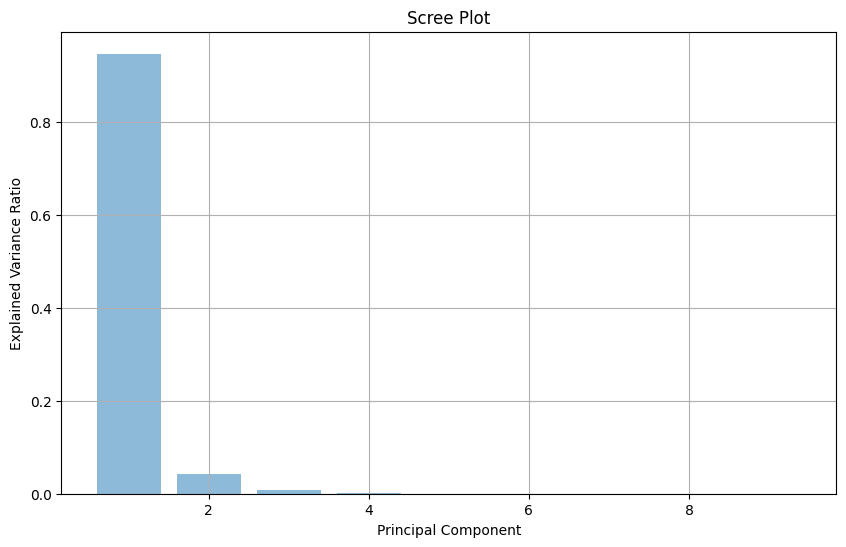

In [67]:
data_numeric = yield_data.drop(columns=['Date'])

# Handle missing values if any
data_numeric.dropna(inplace=True)

# Standardize the data
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data_numeric)

# Apply PCA
pca = PCA()
pca.fit(data_scaled)

# Get the explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_

# Print the explained variance ratio for each principal component
print("Explained Variance Ratio for each Principal Component:")
for i, ratio in enumerate(explained_variance_ratio):
    print(f"PC{i+1}: {ratio:.4f}")

# You can also access the principal components themselves
principal_components = pca.components_

# Transform the original data to the new PCA space
data_pca = pca.transform(data_scaled)

# Convert the transformed data to a DataFrame for further analysis if needed
data_pca_df = pd.DataFrame(data_pca, columns=[f'PC{i+1}' for i in range(data_pca.shape[1])])

# Plot the explained variance ratio
plt.figure(figsize=(10, 6))
plt.bar(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, alpha=0.5, align='center')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.title('Scree Plot')
plt.grid()
plt.show()

In [68]:
# Convert the data to montly data by taking the last value of each month
yield_data = yield_data.resample('M', on='Date').last()
yield_data['Date'] = yield_data.index

# Change the format of the index to montly. i.e. "2011-05-31" to "2011-05"
yield_data.index = yield_data.index.strftime('%Y-%m')

display(yield_data)

,X30,X90,X180,X360,X720,X1080,X1800,X2520,X3600,Date
Date,,,,,,,,,,
2011-05,7.332100,7.781600,8.214500,8.714200,9.135900,9.290000,9.470500,9.638400,9.894900,2011-05-31
2011-06,7.733400,8.118900,8.498800,8.967900,9.356900,9.492000,9.616600,9.700900,9.805200,2011-06-30
2011-07,8.416700,8.253600,8.294300,8.612200,9.056800,9.298400,9.588300,9.761500,9.917100,2011-07-31
2011-08,7.643700,7.513200,7.591300,7.888300,8.205800,8.357400,8.617400,8.912500,9.390000,2011-08-31
2011-09,7.026800,7.410700,7.805400,8.231700,8.561800,8.716000,9.047700,9.490400,10.267300,2011-09-30
...,...,...,...,...,...,...,...,...,...,...
2021-08,18.941601,18.883088,18.796276,18.619718,18.291762,18.008577,17.556980,17.228069,16.858997,2021-08-31
2021-09,17.866262,17.898367,17.949710,18.071199,18.341332,18.580971,18.847544,18.863872,18.609680,2021-09-30
2021-10,16.749763,16.949911,17.221743,17.747919,18.618549,19.291030,20.139658,20.483604,20.465098,2021-10-31


In [69]:
# Calculate differences and make a new DataFrame
for i in range(1, len(yield_data.columns)):
    yield_data[yield_data.columns[i] + '_diff'] = yield_data[yield_data.columns[i]] - yield_data[yield_data.columns[i]].shift(1)

# Drop the first row since it will have NaN values due to differencing
yield_data.dropna(inplace=True)

# Calculate descriptive statistics
statistics = pd.DataFrame(columns=['Variable', 'Mean', 'Median', 'Skewness', 'Kurtosis'])

for column in yield_data.columns[1:]:
    variable = column.split('_')[0]
    mean = np.mean(yield_data[column])
    median = np.median(yield_data[column])
    sk = skew(yield_data[column])
    kurt = kurtosis(yield_data[column])
    # Creating a new DataFrame with the new row
    new_row = pd.DataFrame([{'Variable': variable, 'Mean': mean, 'Median': median, 'Skewness': sk, 'Kurtosis': kurt}])

    # Concatenating the new row to the existing DataFrame
    statistics = pd.concat([statistics, new_row], ignore_index=True)
display(statistics)

UFuncTypeError: ufunc 'add' cannot use operands with types dtype('<M8[ns]') and dtype('<M8[ns]')

### Part C - a: ChatGPT Comments
- The interest rate levels show a consistent right-skewed distribution across different time intervals, with heavier tails indicating the presence of outliers or extreme values.
- Interest rate differences display even heavier tails with significantly higher kurtosis values, suggesting extreme fluctuations or outliers in the data.
- The skewness values for interest rate differences vary, indicating varying degrees of right-skewness in the changes over time.
- Extremely high kurtosis values for interest rate differences suggest that the distribution of changes in interest rates deviates significantly from a normal distribution, indicating high volatility or non-stationarity in the data.

### Part C - b:

In [ ]:
# Count the number of months where yields are positive
positive_10Y = (yield_data['X3600'] > 0).sum()
positive_2Y = (yield_data['X720'] > 0).sum()

print("Number of months with positive 10-year yield:", positive_10Y)
print("Number of months with positive 2-year yield:", positive_2Y)

Number of months with positive 10-year yield: 125
Number of months with positive 2-year yield: 125


In [ ]:
# Calculate the yield spread (e.g., 10-year minus 2-year)
yield_data['yield_spread'] = (yield_data['X3600'] - yield_data['X720'])

flatten_threshold = 0.5
steepen_threshold = 4

flatten_months = []
for i in range(len(yield_data)):
    if abs(yield_data['yield_spread'].iloc[i]) < flatten_threshold:
        flatten_months.append(yield_data.index[i])
steepen_months = []
for i in range(len(yield_data)):
    if abs(yield_data['yield_spread'].iloc[i]) > steepen_threshold:
        steepen_months.append(yield_data.index[i])
steepen_months

['2018-08', '2018-09', '2018-10', '2019-01', '2019-04', '2019-05', '2020-06']

flatten periods

'2012-01',
 '2012-02',
 '2012-03',
 '2012-04',
 '2012-05',
 '2012-06',

 '2013-11',
 '2013-12',

 '2014-08',
 '2014-09',
 '2014-10',
 '2014-11',
 '2014-12',
 '2015-01',
 '2015-02',
 '2015-03'


 steepen periods

 
 '2018-08', '2018-09', '2018-10'

 '2019-04', '2019-05', '2020-06'

Explained Variance Ratio for each Principal Component:
Year 2013:
PC1: 0.9819
PC2: 0.0150
PC3: 0.0026
PC4: 0.0005
PC5: 0.0001
PC6: 0.0000
PC7: 0.0000
PC8: 0.0000
PC9: 0.0000

Year 2018:
PC1: 0.8917
PC2: 0.0905
PC3: 0.0132
PC4: 0.0046
PC5: 0.0000
PC6: 0.0000
PC7: 0.0000
PC8: 0.0000
PC9: 0.0000

Year 2019:
PC1: 0.9336
PC2: 0.0428
PC3: 0.0218
PC4: 0.0018
PC5: 0.0000
PC6: 0.0000
PC7: 0.0000
PC8: 0.0000
PC9: 0.0000


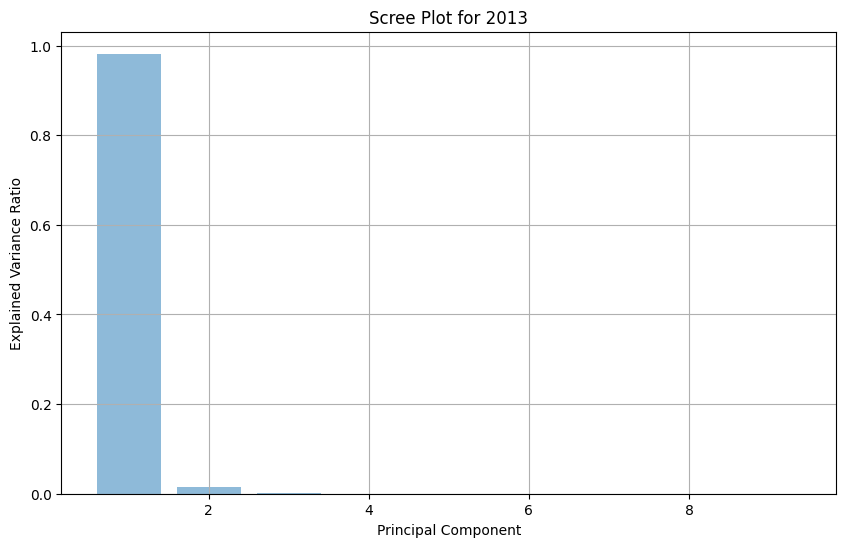

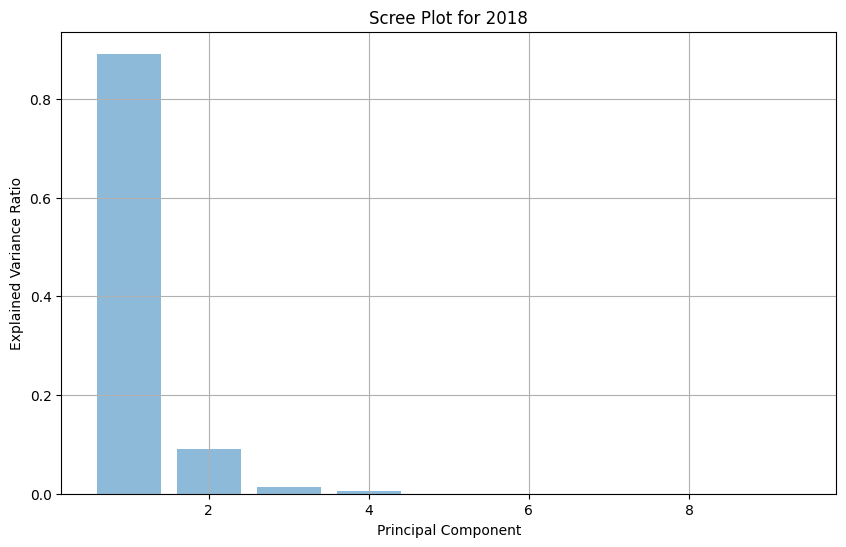

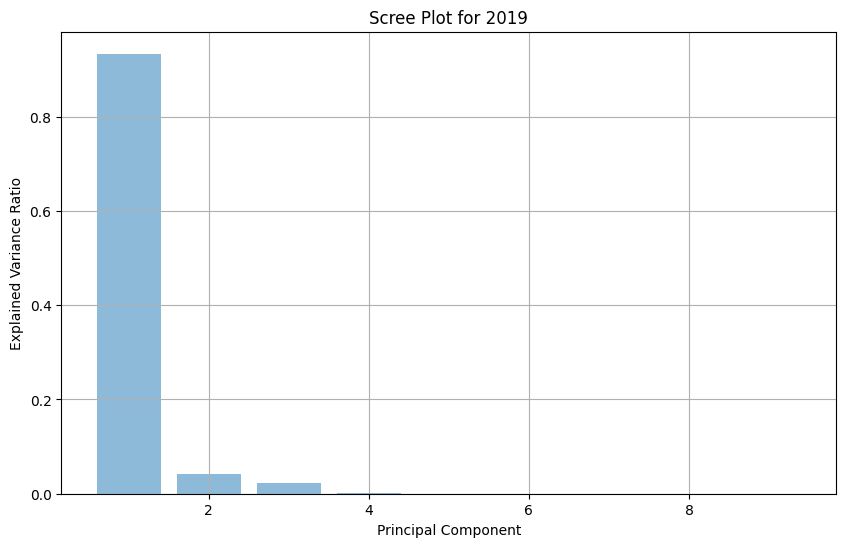

In [ ]:
# Filter data for each year
data_2013 = yield_data[yield_data['Date'].dt.year == 2013].copy()
data_2018 = yield_data[yield_data['Date'].dt.year == 2018].copy()
data_2019 = yield_data[yield_data['Date'].dt.year == 2019].copy()

# Call only the ['X30', 'X90', 'X180', 'X360', 'X720', 'X1080', 'X1800', 'X2520','X3600'] columns
data_2013_numeric = data_2013[['X30', 'X90', 'X180', 'X360', 'X720', 'X1080', 'X1800', 'X2520','X3600']]
data_2018_numeric = data_2018[['X30', 'X90', 'X180', 'X360', 'X720', 'X1080', 'X1800', 'X2520','X3600']]
data_2019_numeric = data_2019[['X30', 'X90', 'X180', 'X360', 'X720', 'X1080', 'X1800', 'X2520','X3600']]

# Handle missing values if any
data_2013_numeric.dropna(inplace=True)
data_2018_numeric.dropna(inplace=True)
data_2019_numeric.dropna(inplace=True)

# Standardize the data
scaler = StandardScaler()
data_2013_scaled = scaler.fit_transform(data_2013_numeric)
data_2018_scaled = scaler.fit_transform(data_2018_numeric)
data_2019_scaled = scaler.fit_transform(data_2019_numeric)

# Apply PCA for each year
pca_2013 = PCA()
pca_2013.fit(data_2013_scaled)
pca_2018 = PCA()
pca_2018.fit(data_2018_scaled)
pca_2019 = PCA()
pca_2019.fit(data_2019_scaled)

# Get the explained variance ratio for each year
explained_variance_ratio_2013 = pca_2013.explained_variance_ratio_
explained_variance_ratio_2018 = pca_2018.explained_variance_ratio_
explained_variance_ratio_2019 = pca_2019.explained_variance_ratio_

# Print the explained variance ratio for each principal component for each year
print("Explained Variance Ratio for each Principal Component:")
print("Year 2013:")
for i, ratio in enumerate(explained_variance_ratio_2013):
    print(f"PC{i+1}: {ratio:.4f}")

print("\nYear 2018:")
for i, ratio in enumerate(explained_variance_ratio_2018):
    print(f"PC{i+1}: {ratio:.4f}")

print("\nYear 2019:")
for i, ratio in enumerate(explained_variance_ratio_2019):
    print(f"PC{i+1}: {ratio:.4f}")

# Plot the explained variance ratio for each year
plt.figure(figsize=(10, 6))
plt.bar(range(1, len(explained_variance_ratio_2013) + 1), explained_variance_ratio_2013, alpha=0.5, align='center')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.title('Scree Plot for 2013')
plt.grid()
plt.show()

plt.figure(figsize=(10, 6))
plt.bar(range(1, len(explained_variance_ratio_2018) + 1), explained_variance_ratio_2018, alpha=0.5, align='center')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.title('Scree Plot for 2018')
plt.grid()
plt.show()

plt.figure(figsize=(10, 6))
plt.bar(range(1, len(explained_variance_ratio_2019) + 1), explained_variance_ratio_2019, alpha=0.5, align='center')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.title('Scree Plot for 2019')
plt.grid()
plt.show()


# Part D

In [ ]:
logit_data = pd.read_csv('csv_files/logit1.csv')

# Split the data as test and train
X = logit_data[['WCTA', 'RETA', 'EBITTA', 'METL', 'STA']]
y = logit_data['default']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [87]:
# Helper function to plot the neural network
def plot_nn(model):
    layers = [model.input_shape[1]] + [layer.units for layer in model.layers]
    G = nx.DiGraph()

    # Create nodes for each layer
    pos = {}
    node_idx = 0
    for l, layer_size in enumerate(layers):
        for n in range(layer_size):
            G.add_node(node_idx, layer=l, pos=(l, n))
            pos[node_idx] = (l, -n)
            node_idx += 1

    # Create edges between layers
    layer_start_idx = 0
    for l, (layer_size_in, layer_size_out) in enumerate(zip(layers[:-1], layers[1:])):
        for i in range(layer_size_in):
            for j in range(layer_size_out):
                G.add_edge(layer_start_idx + i, layer_start_idx + layer_size_in + j)
        layer_start_idx += layer_size_in

    # Plot the graph
    plt.figure(figsize=(6, 4))
    nx.draw(G, pos, with_labels=False, node_size=500, node_color="skyblue", 
            edge_color="k", linewidths=1, font_size=15, arrows=True, arrowsize=20)
    plt.title("Neural Network Architecture")
    plt.show()

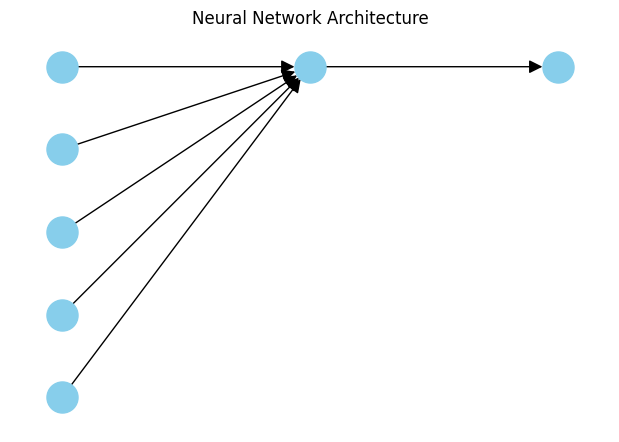

In [88]:
# Define the model
model1 = Sequential()
model1.add(Dense(1, input_dim=5, activation='relu'))
model1.add(Dense(1, activation='sigmoid'))

# Plot the neural network
plot_nn(model1)

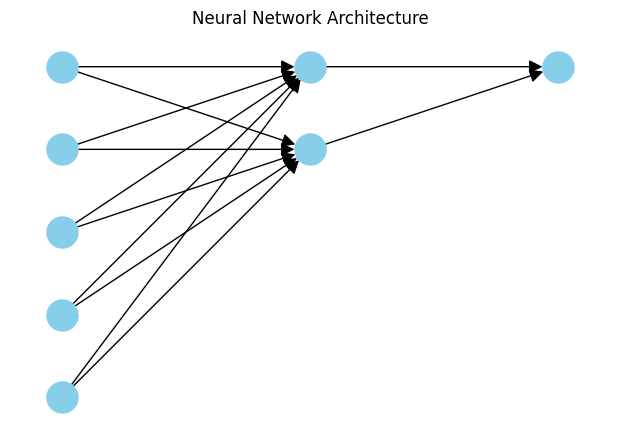

In [89]:
model2 = Sequential()

model2.add(Dense(2, input_dim=5, activation='relu'))
model2.add(Dense(1, activation='sigmoid'))

plot_nn(model2)

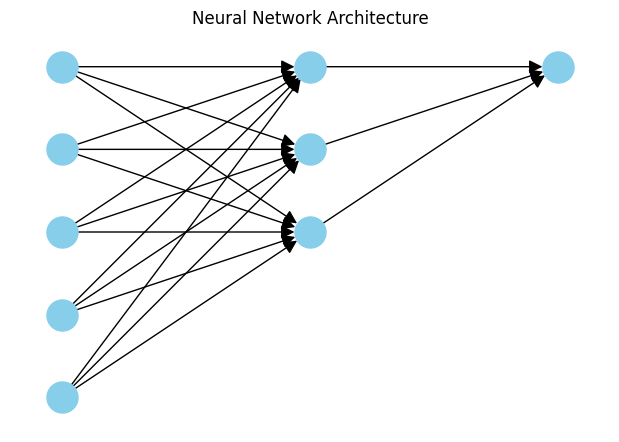

In [90]:
model3= Sequential()

model3.add(Dense(3, input_dim=5, activation='relu'))
model3.add(Dense(1, activation='sigmoid'))

plot_nn(model3)

In [91]:
model1.compile(loss='mse', optimizer='adam', metrics=['accuracy'])
model2.compile(loss='mse', optimizer='adam', metrics=['accuracy'])
model3.compile(loss='mse', optimizer='adam', metrics=['accuracy'])

# Fit the model
model1.fit(X_train, y_train, epochs=100, batch_size=10, verbose=0)
model2.fit(X_train, y_train, epochs=100, batch_size=10, verbose=0)
model3.fit(X_train, y_train, epochs=100, batch_size=10, verbose=0)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


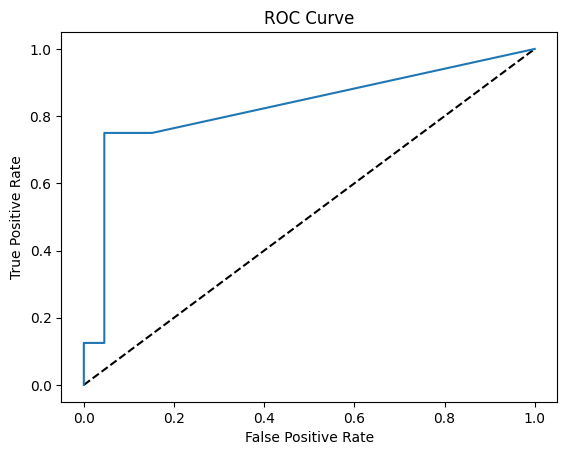

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


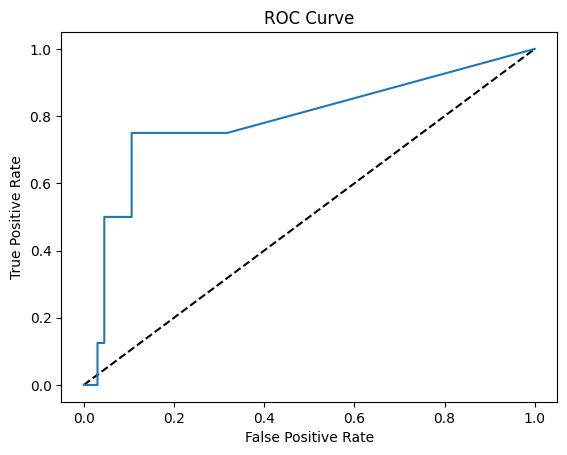

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


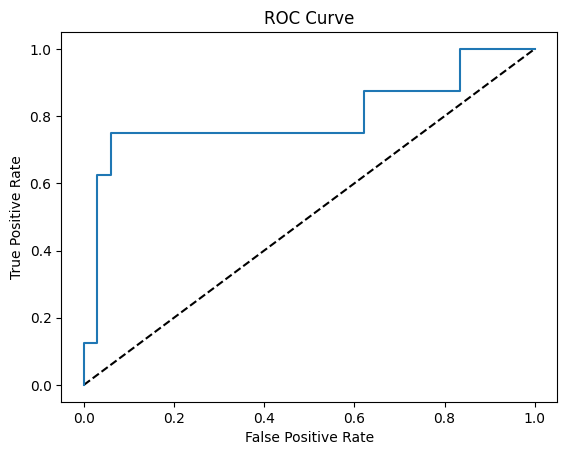

Model 1 AUC: 0.8276515151515151
Model 2 AUC: 0.787878787878788
Model 3 AUC: 0.7954545454545454


In [92]:
# Plot ROC Curve for each model
y_pred1 = model1.predict(X_test)
fpr1, tpr1, thresholds1 = roc_curve(y_test, y_pred1)
plt.plot([0,1],[0,1],'k--')
plt.plot(fpr1,tpr1, label='Model 1')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

y_pred2 = model2.predict(X_test)
fpr2, tpr2, thresholds2 = roc_curve(y_test, y_pred2)
plt.plot([0,1],[0,1],'k--')
plt.plot(fpr2,tpr2, label='Model 2')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

y_pred3 = model3.predict(X_test)
fpr3, tpr3, thresholds3 = roc_curve(y_test, y_pred3)
plt.plot([0,1],[0,1],'k--')
plt.plot(fpr3,tpr3, label='Model 3')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

# Calculate area under the curve for each model
auc1 = roc_auc_score(y_test, y_pred1)
auc2 = roc_auc_score(y_test, y_pred2)
auc3 = roc_auc_score(y_test, y_pred3)

print("Model 1 AUC:", auc1)
print("Model 2 AUC:", auc2)
print("Model 3 AUC:", auc3)

Model 1 is the best.

In [97]:
# Calculate(TP+TN)/(TP+TN+FP+FN) and find the best threshold
thresholds = np.linspace(0, 1, 100)
accuracy = []
for threshold in thresholds:
    y_pred = (model1.predict(X_test) > threshold).astype(int)
    accuracy.append(accuracy_score(y_test, y_pred))

best_threshold = thresholds[np.argmax(accuracy)]
print("Best Threshold for Model 1:", best_threshold)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 620us/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 545us/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 517us/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 539us/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 563us/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 599us/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 528us/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 757us/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 729us/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 513us/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 505us/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 625us/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 535us/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 514us/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 689us/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 525us/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 513us/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 675us/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 517us/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 537us/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 516us/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 663us/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 543us/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 509us/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 553us/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 

In [96]:
# Calculate(TP+TN)/(TP+TN+FP+FN) and find the best threshold
thresholds = np.linspace(0, 1, 100)
accuracy = []
for threshold in thresholds:
    y_pred = (model2.predict(X_test) > threshold).astype(int)
    accuracy.append(accuracy_score(y_test, y_pred))

best_threshold = thresholds[np.argmax(accuracy)]
print("Best Threshold for Model 2:", best_threshold)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 686us/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 831us/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 724us/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 548us/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 843us/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 686us/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 530us/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 846us/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 543us/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 660us/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 652us/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 515us/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 599us/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 556us/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 573us/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 548us/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 512us/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 585us/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 528us/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 854us/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 526us/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 597us/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 778us/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 

In [98]:
# Calculate(TP+TN)/(TP+TN+FP+FN) and find the best threshold
thresholds = np.linspace(0, 1, 100)
accuracy = []
for threshold in thresholds:
    y_pred = (model3.predict(X_test) > threshold).astype(int)
    accuracy.append(accuracy_score(y_test, y_pred))

best_threshold = thresholds[np.argmax(accuracy)]
print("Best Threshold for Model 3:", best_threshold)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 636us/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 657us/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 554us/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 553us/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 595us/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 527us/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 583us/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 625us/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 850us/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 567us/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 555us/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 640us/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 748us/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 597us/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 759us/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 547us/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 996us/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 637us/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 524us/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 563us/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 684us/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 652us/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 776us/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s

Best Threshold for Model 1: 0.20202020202020204

Best Threshold for Model 2: 0.16161616161616163

Best Threshold for Model 3: 0.10101010101010102

# Part E

## Part E - a

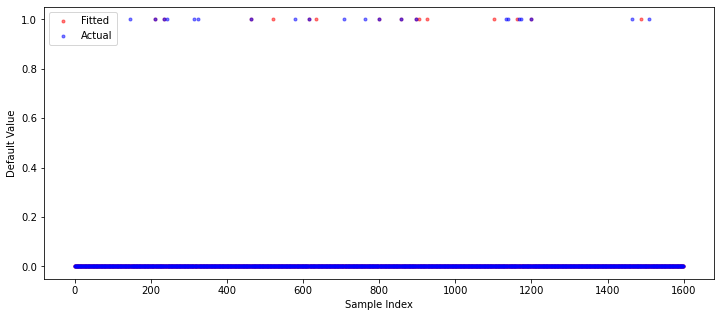

In [124]:
# Load the data
logit_data = pd.read_csv('csv_files/logit1.csv')
df = logit_data.copy()

# Split the data into training and testing sets
X = df.drop(columns='default')
y = df['default']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

# Train the decision tree model
clf = DecisionTreeClassifier(random_state=42, max_depth=5, min_samples_leaf=5, min_samples_split=100)
clf.fit(X_train, y_train)

# Predict the test data
y_pred_proba = clf.predict_proba(X_test)[:, 1]

# Use 0.50 as the threshold
y_pred_50 = (y_pred_proba >= 0.50).astype(int)

# Plot fitted vs actual data
plt.figure(figsize=(12, 5))
plt.scatter(range(len(y_test)), y_pred_50, color='red', marker='.', label='Fitted', alpha=0.5)
plt.scatter(range(len(y_test)), y_test, color='blue', label='Actual', marker='.', alpha=0.5)
plt.xlabel('Sample Index')
plt.ylabel('Default Value')
plt.legend()
plt.show()

## Part E - b

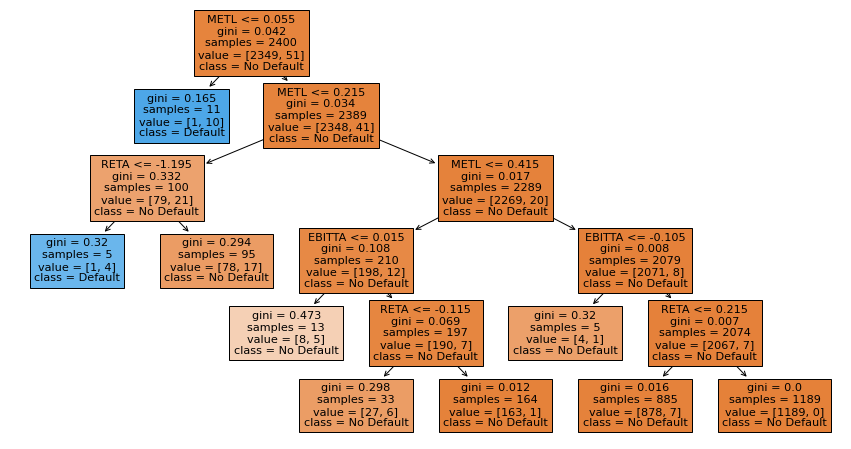

In [128]:
# Plot the decision tree
plt.figure(figsize=(15, 8))
plot_tree(clf, feature_names=X.columns, class_names=['No Default', 'Default'], filled=True)
plt.show()

## Part E - c

In [126]:
# Use 0.75 as the threshold
y_pred_75 = (y_pred_proba >= 0.75).astype(int)

# Create confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_75)

# Calculate accuracy ratio
accuracy = accuracy_score(y_test, y_pred_75)

print("Confusion Matrix:")
print(conf_matrix)
print(f"Accuracy Ratio: {accuracy:.2f}")

Confusion Matrix:
[[1572    7]
 [  13    8]]
Accuracy Ratio: 0.99


## Part E - d

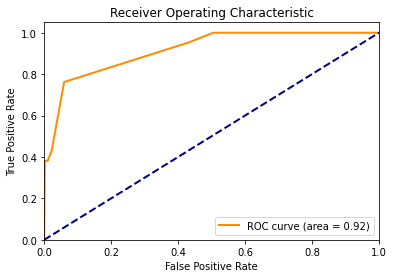

In [127]:
# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = roc_auc_score(y_test, y_pred_proba)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()